In [1]:
import os
import pickle
import logging

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import pandas as pd
from pandas.testing import assert_frame_equal

import arviz as az
from numpyro.diagnostics import hpdi

from hbmep.config import Config
from hbmep.nn import functional as F
from hbmep.model.utils import Site as site

from hbmep_paper.utils import setup_logging
from models import (
    MixtureModel,
    RectifiedLogistic,
    Logistic5,
    Logistic4,
    RectifiedLinear
)
from constants import (
    DATA_PATH,
    INFERENCE_FILE,
    BUILD_DIR
)
from compare import (
    POSTERIOR_DIRS,
    FUNCTIONAL_MODELS,
    MIXTURE_MODELS
)

plt.rcParams["svg.fonttype"] = "none"
logger = logging.getLogger(__name__)

os.makedirs(BUILD_DIR, exist_ok=True)
setup_logging(
    dir=BUILD_DIR,
    fname="figure__cross-validation"
)

N_PULSES = 5000


2024-06-06 23:22:39,910 - hbmep_paper.utils.utils - INFO - Logging to /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/figure__cross-validation.log


In [2]:
src = os.path.join(BUILD_DIR, "compare_functional.pkl")
with open(src, "rb") as f:
    compare_functional, = pickle.load(f)

src = os.path.join(BUILD_DIR, "compare_mixture.pkl")
with open(src, "rb") as f:
    compare_mixture, = pickle.load(f)

print(compare_functional.keys())
print(compare_mixture.keys())


dict_keys(['rats', 'tms', 'intraoperative'])
dict_keys(['rats', 'tms', 'intraoperative'])


In [3]:
RAT_DIR = [u[1] for u in POSTERIOR_DIRS if u[0] == "rats"][0]
TMS_DIR = [u[1] for u in POSTERIOR_DIRS if u[0] == "tms"][0]

print(RAT_DIR)
print(TMS_DIR)


/home/vishu/repos/hbmep-paper/reports/cross-validation/rats
/home/vishu/repos/hbmep-paper/reports/cross-validation/tms


In [4]:
src = DATA_PATH
RAT_DF = pd.read_csv(DATA_PATH)

src = "/home/vishu/data/hbmep-processed/human/tms/proc_2024-05-16.csv"
TMS_DF = pd.read_csv(src)


In [5]:
def make_example(dir, data, example_value, min_intensity, max_intensity, models):
    example = {}
    for model_dir, model_name, functional, named_params in models:
        print(model_dir, named_params)
        src = os.path.join(dir, model_dir, INFERENCE_FILE)
        with open(src, "rb") as f:
            model, _, posterior_samples = pickle.load(f)

        df, encoder_dict = model.load(df=data)

        c = (encoder_dict[model.features[0]].transform([example_value])[0],)
        ind = df[model.features].apply(tuple, axis=1).isin([c])
        df = df[ind].reset_index(drop=True).copy()

        p = None
        if "p" in posterior_samples.keys():
            p = posterior_samples["p"]
            p = p[:, ind, ...]
            outlier_prob = (
                1 - jnp.mean(jnp.exp(p[..., 0]), axis=0)
            )

        prediction_df = model.make_prediction_dataset(
            df=df,
            num_points=N_PULSES,
            min_intensity=min_intensity,
            max_intensity=max_intensity
        )
        posterior_predictive = model.predict(df=prediction_df, posterior_samples=posterior_samples)

        ind = prediction_df[model.features].apply(tuple, axis=1).isin([c])
        obs = posterior_predictive[site.obs][:, ind, ...]

        pulses = prediction_df[model.intensity].to_numpy()
        params = [posterior_samples[name_param][:, *c, ...].mean(axis=0)[None, :] for name_param in named_params]
        out = functional(pulses[:, None], *params)

        example[model_dir] = {
            "model": model,
            "model_name": model_name,
            "df": df,
            "prediction_df": prediction_df,
            "obs": obs,
            "obs_hdi": hpdi(obs, prob=.95),
            "out": out,
            "outlier_prob": outlier_prob if p is not None else None
        }

    return example


In [6]:
example_functional = make_example(
    dir = RAT_DIR,
    data = RAT_DF.copy(),
    example_value = "amap05___C5M-C6L",
    min_intensity = 0.,
    max_intensity = 205.,
    models = FUNCTIONAL_MODELS
)


2024-06-06 23:22:40,140 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2024-06-06 23:22:40,140 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-06-06 23:22:40,141 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-06-06 23:22:40,141 - jax._src.xla_bridge - WARNING - An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


rectified_logistic ['a', 'b', 'L', 'ℓ', 'H']


2024-06-06 23:22:44,053 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/rectified_logistic
2024-06-06 23:22:44,064 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:22:44,065 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:22:44,088 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:23:26,811 - hbmep.utils.utils - INFO - func:predict took: 42.72 sec


logistic5 ['a', 'b', 'v', 'L', 'H']


2024-06-06 23:23:36,605 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/logistic5
2024-06-06 23:23:36,616 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:23:36,617 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:23:36,895 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:24:21,682 - hbmep.utils.utils - INFO - func:predict took: 44.79 sec


logistic4 ['a', 'b', 'L', 'H']


2024-06-06 23:24:29,448 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/logistic4
2024-06-06 23:24:29,459 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:24:29,460 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:24:29,618 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:25:11,227 - hbmep.utils.utils - INFO - func:predict took: 41.61 sec


rectified_linear ['a', 'b', 'L']


2024-06-06 23:25:20,624 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/rectified_linear
2024-06-06 23:25:20,634 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:25:20,636 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:25:20,868 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:26:02,654 - hbmep.utils.utils - INFO - func:predict took: 41.79 sec


In [7]:
for model_dir in example_functional.keys():
    assert_frame_equal(example_functional[model_dir]["df"], example_functional["rectified_logistic"]["df"], check_names=False)
    assert_frame_equal(example_functional[model_dir]["prediction_df"], example_functional["rectified_logistic"]["prediction_df"], check_names=False)


In [8]:
example_functional.keys()


dict_keys(['rectified_logistic', 'logistic5', 'logistic4', 'rectified_linear'])

In [9]:
example_mixture = make_example(
    dir = TMS_DIR,
    data = TMS_DF.copy(),
    example_value = "SCA07___Uninjured",
    min_intensity = 0.,
    max_intensity = 90.,
    models = MIXTURE_MODELS
)

# for u in example_mixture.keys():
#     if u == "rectified_logistic":
#         model_name = "Rectified-logistic\nGamma distribution"
#     else:
#         model_name = "Rectified-logistic\nMixture distribution"

#     print(f"Changing for {u} from {example_mixture[u]['model_name']} to {model_name}")
#     example_mixture[u]["model_name"] = model_name


mixture_model ['a', 'b', 'L', 'ℓ', 'H']


2024-06-06 23:26:08,971 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/tms/mixture_model
2024-06-06 23:26:08,975 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:26:08,976 - hbmep.utils.utils - INFO - func:load took: 0.00 sec
2024-06-06 23:26:09,033 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.01 sec
2024-06-06 23:26:54,193 - hbmep.utils.utils - INFO - func:predict took: 45.16 sec


rectified_logistic ['a', 'b', 'L', 'ℓ', 'H']


2024-06-06 23:26:59,045 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/tms/rectified_logistic
2024-06-06 23:26:59,049 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:26:59,050 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:26:59,056 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:27:40,774 - hbmep.utils.utils - INFO - func:predict took: 41.72 sec


In [10]:
for model_dir in example_mixture.keys():
    assert_frame_equal(example_mixture[model_dir]["df"], example_mixture["rectified_logistic"]["df"], check_names=False)
    assert_frame_equal(example_mixture[model_dir]["prediction_df"], example_mixture["rectified_logistic"]["prediction_df"], check_names=False)


In [11]:
example_additional = make_example(
    dir = RAT_DIR,
    data = RAT_DF.copy(),
    example_value = "amap05___C5M-C6L",
    min_intensity = 0.,
    max_intensity = 205.,
    models = MIXTURE_MODELS[:1]
)

# example_additional["mixture_model"]["model_name"] = "Rectified-logistic\nMixture distribution"


mixture_model ['a', 'b', 'L', 'ℓ', 'H']


2024-06-06 23:27:52,332 - hbmep.dataset.core - INFO - Artefacts will be stored here - /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/mixture_model
2024-06-06 23:27:52,343 - hbmep.dataset.core - INFO - Processing data ...
2024-06-06 23:27:52,344 - hbmep.utils.utils - INFO - func:load took: 0.01 sec
2024-06-06 23:27:52,356 - hbmep.utils.utils - INFO - func:make_prediction_dataset took: 0.00 sec
2024-06-06 23:28:40,619 - hbmep.utils.utils - INFO - func:predict took: 48.26 sec


In [12]:
max_color_values = (255, 255, 255, 100)
posterior_color = (204, 204, 204, 15)
posterior_color = tuple([u / v for u, v in zip(posterior_color, max_color_values)])

curve_color = (51, 51, 51, 100)
curve_color = tuple([u / v for u, v in zip(curve_color, max_color_values)])

scatter_color = (179, 179, 179, 100)
scatter_color = tuple([u / v for u, v in zip(scatter_color, max_color_values)])

scatter_edge_color = (255, 255, 255, 100)
scatter_edge_color = tuple([u / v for u, v in zip(scatter_edge_color, max_color_values)])

colorbar_cmap = sns.color_palette(f'blend:{scatter_color[0]},red', as_cmap=True)


In [13]:
def plot_ppd(ax, example, response_ind, outlier_prob=None):
    model, model_name, df, prediction_df, obs, obs_hdi, out, outlier_prob = (
        example["model"],
        example["model_name"],
		example["df"],
        example["prediction_df"],
		example["obs"],
		example["obs_hdi"],
		example["out"],
        example["outlier_prob"]
    )
    ax.fill_between(
        prediction_df[model.intensity],
        obs_hdi[0, :, response_ind],
        obs_hdi[1, :, response_ind],
        color=posterior_color
    )
    if outlier_prob is not None:
        sns.scatterplot(
            x=df[model.intensity],
            y=df[model.response[response_ind]],
            # c=outlier_prob[:, response_ind],
            # cmap="coolwarm",
            palette=colorbar_cmap,
            hue=outlier_prob[:, response_ind],
            edgecolor=scatter_edge_color,
            ax=ax,
            legend=False,
        )
    else:
        sns.scatterplot(
            x=df[model.intensity],
            y=df[model.response[response_ind]],
            color=scatter_color,
            edgecolor=scatter_edge_color,
            ax=ax
        )
    sns.lineplot(x=prediction_df[model.intensity], y=out[:, response_ind], color=curve_color, ax=ax, linewidth=2)
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    return


def plot_compare_df(ax, compare_df):
    az.plot_compare(comp_df=compare_df, ax=ax)
    ax.legend(loc="upper left")
    ax.get_legend().remove()
    ax.set_xlabel("")
    ax.set_ylabel("")
    ax.set_title("")
    return


2024-06-06 23:28:46,364 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/cross_validation_functional.png


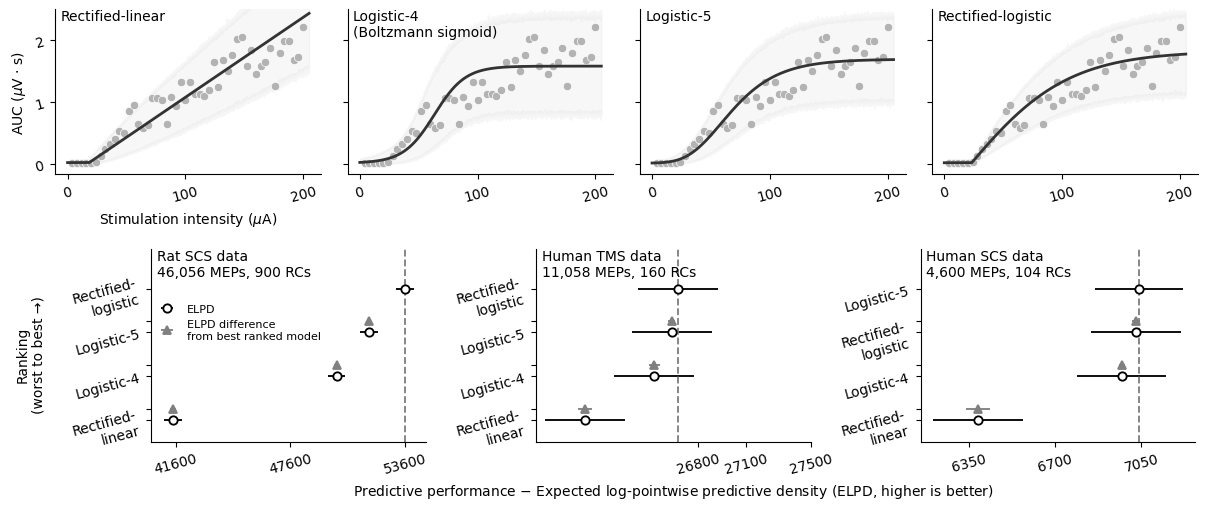

In [14]:
axis_label_size = 10
inset_text_size = 10
legend_text_size = 8

fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(2, 1)

""" Functional comparison """
subfig = subfigs.flat[0]
axes = subfig.subplots(1, 4, sharex=True, sharey=True, squeeze=False)
example_functional_axes = axes

for i, (ax, model_name) in enumerate(zip(axes.flat, ["rectified_linear", "logistic4", "logistic5", "rectified_logistic"])):
    example = example_functional[model_name]
    plot_ppd(ax, example, response_ind=1)
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_size
    )
    model_name = example["model_name"]
    match model_name:
        case "Rectified-\nlinear":
            model_name = "Rectified-linear"
        case "Rectified-\nlogistic":
            model_name = "Rectified-logistic"
        case "Logistic-4":
            model_name = "Logistic-4\n(Boltzmann sigmoid)"

    ax.text(0.02, 1, model_name, fontsize=inset_text_size, va="top", transform=ax.transAxes)

ax = axes[0, 0]
ax.set_xticks([0., 100., 200.])
ax.set_yticks([0., 1., 2.])
ax.set_ylim(top=2.5)
ax.tick_params(labelleft=True, labelsize=axis_label_size)

ax = axes[0, 0]
ax.set_ylabel("AUC $(\mu$V $\cdot$ s)", fontsize=axis_label_size)
ax.set_xlabel("Stimulation intensity $(\mu$A)", fontsize=axis_label_size)
subfig.subplots_adjust(left=.04, right=.992, bottom=.32, top=.98, wspace=.1)

subfig = subfigs.flat[1]
axes = subfig.subplots(1, 3, squeeze=False)
compare_functional_axes = axes

for i, (ax, dataset) in enumerate(zip(axes.flat, ["rats", "tms", "intraoperative"])):
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    labelleft = True
    compare_df = compare_functional[dataset]
    plot_compare_df(ax, compare_df)
    ax.tick_params(labelbottom=True)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=labelleft,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_size
    )

    ax.tick_params(axis="x", labelsize=axis_label_size)
    match i:
        case 0:
            handles, previous_labels = ax.get_legend_handles_labels()
            ax.legend(
                handles=handles,
                labels=["ELPD", "ELPD difference\nfrom best ranked model"],
                fontsize=legend_text_size,
                loc=(0., .5),
                frameon=False
            )
            xticks = [41600, 47600, 53600]
        case 1:
            xticks = [26800, 27100, 27500]
        case 2:
            xticks = [6350, 6700, 7050]
    ax.set_xticks(xticks)
    ax.set_ylim(top=.3)
    # ax.xaxis.set_major_locator(plt.MaxNLocator(3))

for i in range(3):
    ax = axes[0, i]
    match i:
        case 0:
            x = 40700
            label = "Rat SCS data\n46,056 MEPs, 900 RCs"
        case 1:
            x = 26570
            label = "Human TMS data\n11,058 MEPs, 160 RCs"
        case 2:
            x = 6185
            label = "Human SCS data\n4,600 MEPs, 104 RCs"
    ax.text(0.02, 1, label, fontsize=inset_text_size, va="top", transform=ax.transAxes)

ax = axes[0, 0]
ax.text(34000, -.5, "Ranking\n(worst to best →)", fontsize=axis_label_size, rotation=90, va="center", ha="center")
ax = axes[0, 1]
ax.set_xlabel("Predictive performance $-$ Expected log-pointwise predictive density (ELPD, higher is better)", fontsize=axis_label_size)
subfig.subplots_adjust(left=.12, right=.99, bottom=.25, top=1.02, wspace=.4)


fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(BUILD_DIR, "cross_validation_functional.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "cross_validation_functional.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")


2024-06-06 23:28:47,244 - __main__ - INFO - Saved to /home/vishu/repos/hbmep-paper/reports/cross-validation/rats/cross_validation_mixture.png


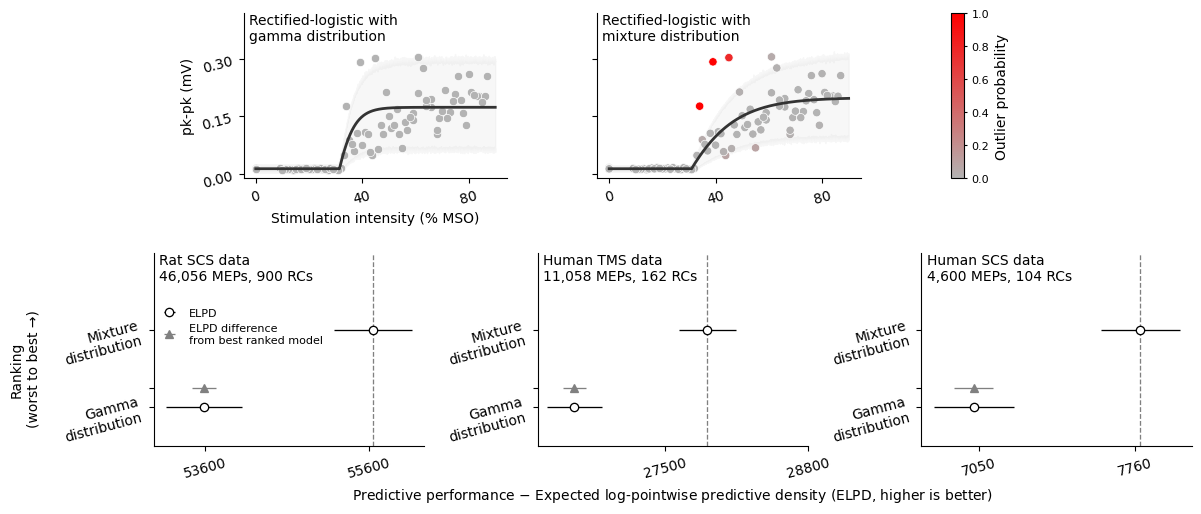

In [15]:
axis_label_size = 10
inset_text_size = 10
legend_text_size = 8

fig = plt.figure(figsize=(12, 5))
subfigs = fig.subfigures(2, 1)

subfig = subfigs.flat[0]
axes = subfig.subplots(1, 3, width_ratios=[1, 1, 0.05], sharex=False, sharey=False, squeeze=False)

response_ind = 4

for i, (ax, model_name) in enumerate(zip(axes.flat, ["rectified_logistic", "mixture_model"])):
    example = example_mixture[model_name]
    plot_ppd(ax, example, response_ind=response_ind)
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=False,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_size
    )
    match example["model_name"]:
        case "Mixture\ndistribution":
            model_name = "Rectified-logistic with\nmixture distribution"
        case "Gamma\ndistribution":
            model_name = "Rectified-logistic with\ngamma distribution"
        case _:
            raise ValueError(f"Unknown model name {example['model_name']}")

    ax.text(0.02, 1, model_name, fontsize=inset_text_size, va="top", transform=ax.transAxes)
    if i in [0, 1]:
        ax.sharex(axes[0, 0])
        ax.sharey(axes[0, 0])

ax = axes[0, 0]
ax.set_xticks([0., 40., 80.])
ax.set_yticks([0., 0.15, .3])
ax.tick_params(labelleft=True, labelsize=axis_label_size)

ax.set_ylabel("pk-pk (mV)", fontsize=axis_label_size)
ax.set_xlabel("Stimulation intensity (% MSO)", fontsize=axis_label_size)
ax.set_ylim(top=.42)
subfig.subplots_adjust(left=.2, right=.8, bottom=.32, top=.98, wspace=.5)

ax = axes[0, 1]
response_ind = 4
outlier_prob = example_mixture["mixture_model"]["outlier_prob"]
norm = plt.Normalize(outlier_prob[:, response_ind].min(), outlier_prob[:, response_ind].max())
sm = plt.cm.ScalarMappable(cmap=colorbar_cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, cax=axes[0, 2], label="Outlier probability", orientation="vertical")
ax = axes[0, 2]
ax.set_yticks([.2 * i for i in range(6)])
ax.tick_params(labelsize=8, length=2)

subfig = subfigs.flat[1]
axes = subfig.subplots(1, 3, squeeze=False)

for i, (ax, dataset) in enumerate(zip(axes.flat, ["rats", "tms", "intraoperative"])):
    sides = ["top", "right"]
    for side in sides:
        ax.spines[side].set_visible(False)
    labelleft = True
    compare_df = compare_mixture[dataset]
    plot_compare_df(ax, compare_df)
    ax.tick_params(labelbottom=True)
    ax.tick_params(
        axis='both',
        which='both',
        left=True,
        bottom=True,
        right=False,
        top=False,
        labelleft=labelleft,
        labelbottom=True,
        labelright=False,
        labeltop=False,
        labelrotation=15,
        labelsize=axis_label_size
    )

    ax.tick_params(axis="x", labelsize=axis_label_size)
    match i:
        case 0:
            handles, previous_labels = ax.get_legend_handles_labels()
            ax.legend(
                handles=handles,
                labels=["ELPD", "ELPD difference\nfrom best ranked model"],
                fontsize=legend_text_size,
                loc=(0.0, .5),
                frameon=False,
            )
            xticks = [53600, 55600]
        case 1:
            xticks = [27500, 28800]
        case 2:
            xticks = [7050, 7760]
    ax.set_xticks(xticks)

    ax.sharey(axes[0, 0])

for i in range(3):
    ax = axes[0, i]
    match i:
        case 0:
            x = 53050
            label = "Rat SCS data\n46,056 MEPs, 900 RCs"
        case 1:
            x = 27150
            label = "Human TMS data\n11,058 MEPs, 162 RCs"
        case 2:
            x = 6830
            label = "Human SCS data\n4,600 MEPs, 104 RCs"
    ax.text(0.02, 1, label, fontsize=inset_text_size, va="top", transform=ax.transAxes)

ax = axes[0, 0]
ax.text(51400, -.5, "Ranking\n(worst to best →)", fontsize=axis_label_size, rotation=90, va="center", ha="center")
ax.set_ylim(top=1)

ax = axes[0, 1]
ax.set_xlabel("Predictive performance $-$ Expected log-pointwise predictive density (ELPD, higher is better)", fontsize=axis_label_size)
subfig.subplots_adjust(left=.125, right=.99, bottom=.25, top=1.02, wspace=.42)

fig.align_xlabels()
fig.align_ylabels()

dest = os.path.join(BUILD_DIR, "cross_validation_mixture.svg")
fig.savefig(dest, dpi=600)

dest = os.path.join(BUILD_DIR, "cross_validation_mixture.png")
fig.savefig(dest, dpi=600)
logger.info(f"Saved to {dest}")


In [16]:
columns = ["rank", "elpd_diff", "dse"]


In [17]:
for u, v in compare_functional.items():
    print(f"\n\n*** {u} ***")
    print(v[columns])




*** rats ***
                      rank     elpd_diff         dse
Rectified-\nlogistic     0      0.000000    0.000000
Logistic-5               1   1866.216284   93.598377
Logistic-4               2   3569.220803  117.345766
Rectified-\nlinear       3  12145.625361  163.164152


*** tms ***
                      rank   elpd_diff        dse
Rectified-\nlogistic     0    0.000000   0.000000
Logistic-5               1   38.055152  22.248227
Logistic-4               2  146.740437  33.755361
Rectified-\nlinear       3  577.124729  43.729517


*** intraoperative ***
                      rank   elpd_diff        dse
Logistic-5               0    0.000000   0.000000
Rectified-\nlogistic     1   11.790563  15.752226
Logistic-4               2   69.377825  11.984742
Rectified-\nlinear       3  652.081426  49.392036


In [18]:
for u, v in compare_mixture.items():
    print(f"\n\n*** {u} ***")
    print(v[columns])




*** rats ***
                       rank    elpd_diff         dse
Mixture\ndistribution     0     0.000000    0.000000
Gamma\ndistribution       1  2060.998056  150.507548


*** tms ***
                       rank    elpd_diff         dse
Mixture\ndistribution     0     0.000000    0.000000
Gamma\ndistribution       1  1210.601324  103.623508


*** intraoperative ***
                       rank   elpd_diff        dse
Mixture\ndistribution     0    0.000000   0.000000
Gamma\ndistribution       1  754.129043  88.772879


In [19]:
src = os.path.join(BUILD_DIR, "compare_functional_no_logistic5.pkl")
with open(src, "rb") as f:
    compare_functional_no_logistic5, = pickle.load(f)

for u, v in compare_functional_no_logistic5.items():
    print(f"\n\n*** {u} ***")
    print(v[columns])




*** rats ***
                      rank     elpd_diff         dse
Rectified-\nlogistic     0      0.000000    0.000000
Logistic-4               1   3569.220803  117.345766
Rectified-\nlinear       2  12145.625361  163.164152


*** tms ***
                      rank   elpd_diff        dse
Rectified-\nlogistic     0    0.000000   0.000000
Logistic-4               1  146.740437  33.755361
Rectified-\nlinear       2  577.124729  43.729517


*** intraoperative ***
                      rank   elpd_diff        dse
Rectified-\nlogistic     0    0.000000   0.000000
Logistic-4               1   57.587262  18.705739
Rectified-\nlinear       2  640.290863  47.634404


In [20]:
# fig = plt.figure(figsize=(12, 5))
# subfigs = fig.subfigures(2, 1)

# """ Functional comparison """
# subfig = subfigs.flat[0]
# axes = subfig.subplots(1, 4, sharex=True, sharey=True, squeeze=False)
# example_functional_axes = axes

# for i, (ax, model_name) in enumerate(zip(axes.flat, ["rectified_linear", "logistic4", "logistic5", "rectified_logistic"])):
#     example = example_functional[model_name]
#     plot_ppd(ax, example, response_ind=1)
#     sides = ["top", "right"]
#     for side in sides:
#         ax.spines[side].set_visible(False)
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=True,
#         bottom=True,
#         right=False,
#         top=False,
#         labelleft=False,
#         labelbottom=True,
#         labelright=False,
#         labeltop=False,
#         labelrotation=15,
#         labelsize=axis_label_size
#     )

# ax = axes[0, 0]
# ax.set_xticks([0., 100., 200.])
# ax.set_yticks([0., 1., 2.])
# ax.set_ylim(top=2.5)
# ax.tick_params(labelleft=True, labelsize=axis_label_size)

# ax = axes[0, 0]
# ax.set_ylabel("AUC $(\mu$V $\cdot$ s)", fontsize=axis_label_size)
# ax.set_xlabel("Stimulation intensity $(\mu$A)", fontsize=axis_label_size)
# subfig.subplots_adjust(left=.04, right=.992, bottom=.32, top=.98, wspace=.1)

# subfig = subfigs.flat[1]
# axes = subfig.subplots(1, 3, squeeze=False)
# compare_functional_axes = axes

# for i, (ax, dataset) in enumerate(zip(axes.flat, ["rats", "tms", "intraoperative"])):
#     sides = ["top", "right"]
#     for side in sides:
#         ax.spines[side].set_visible(False)
#     labelleft = True
#     compare_df = compare_functional[dataset]
#     plot_compare_df(ax, compare_df)
#     ax.tick_params(labelbottom=True)
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=True,
#         bottom=True,
#         right=False,
#         top=False,
#         labelleft=labelleft,
#         labelbottom=True,
#         labelright=False,
#         labeltop=False,
#         labelrotation=15,
#         labelsize=axis_label_size
#     )

#     ax.tick_params(axis="x", labelsize=axis_label_size)
#     match i:
#         case 0:
#             handles, previous_labels = ax.get_legend_handles_labels()
#             ax.legend(handles=handles, labels=["ELPD", "ELPD difference\nfrom best ranked\nmodel"], fontsize=inset_text_size, loc=(0.02, .4))
#             xticks = [42000, 48000, 54000]
#         case 1:
#             xticks = [26800, 27200, 27600]
#         case 2:
#             xticks = [6400, 6800, 7200]
#     ax.set_xticks(xticks)
#     # ax.xaxis.set_major_locator(plt.MaxNLocator(3))

# for i in range(3):
#     ax = axes[0, i]
#     match i:
#         case 0:
#             x = 40700
#             label = "Rat SCS data\n46,056 MEPs, 900 RCs"
#         case 1:
#             x = 26570
#             label = "Human TMS data\n11,058 MEPs, 160 RCs"
#         case 2:
#             x = 6185
#             label = "Human SCS data\n4,600 MEPs, 104 RCs"
#     ax.text(0.02, 1, label, fontsize=inset_text_size, va="top", transform=ax.transAxes)

# ax = axes[0, 0]
# ax.text(34000, -.5, "Ranking\n(worst to best →)", fontsize=axis_label_size, rotation=90, va="center", ha="center")
# ax = axes[0, 1]
# ax.set_xlabel("Predictive performance $-$ Expected log-pointwise predictive density (ELPD, higher is better)", fontsize=axis_label_size)
# subfig.subplots_adjust(left=.12, right=.99, bottom=.25, top=1.02, wspace=.4)

# """ Mixture comparison """
# subfig = subfigs.flat[2]
# axes = subfig.subplots(1, 4, sharex=False, sharey=False, squeeze=False)

# for i, (ax, model_name) in enumerate(zip(axes.flat, [None, None, "rectified_logistic", "mixture_model"])):
#     if i == 1:
#         sides = ["top", "right", "left", "bottom"]
#         for side in sides:
#             ax.spines[side].set_visible(False)
#         ax.tick_params(
#             axis='both',
#             which='both',
#             left=False,
#             bottom=False,
#             right=False,
#             top=False,
#             labelleft=False,
#             labelbottom=False,
#             labelright=False,
#             labeltop=False,
#         )
#         continue

#     example = example_mixture[model_name] if i else example_additional["mixture_model"]

#     plot_ppd(ax, example, response_ind=4 if i else 1)
#     sides = ["top", "right"]
#     for side in sides:
#         ax.spines[side].set_visible(False)
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=True,
#         bottom=True,
#         right=False,
#         top=False,
#         labelleft=False,
#         labelbottom=True,
#         labelright=False,
#         labeltop=False,
#         labelrotation=15,
#         labelsize=axis_label_size
#     )

#     if not i:
#         ax.sharex(example_functional_axes.flat[0])
#         ax.sharey(example_functional_axes.flat[0])
#         ax.tick_params(labelleft=True, labelsize=axis_label_size)
#         ax.set_ylabel("AUC $(\mu$V $\cdot$ s)", fontsize=axis_label_size)
#         ax.set_xlabel("Stimulation intensity $(\mu$A)", fontsize=axis_label_size)
#     else:
#         ax.sharex(axes.flat[2])
#         ax.sharey(axes.flat[2])

#         if i == 2:
#             ax.tick_params(labelleft=True, labelsize=axis_label_size)
#             ax.set_ylabel("pk-pk (mV)", fontsize=axis_label_size)
#             ax.set_xlabel("Stimulation intensity (% MSO)", fontsize=axis_label_size)
#             ax.set_yticks([0., .2, .4])
#             ax.set_ylim(top=.44)

# # ax = axes[0, 0]
# # ax.set_xticks([0., 100., 200.])
# # ax.set_yticks([0., 1., 2.])
# # ax.set_ylim(top=2.5)
# # ax.tick_params(labelleft=True, labelsize=axis_label_size)

# # ax = axes[0, 0]
# # ax.set_ylabel("AUC $(\mu$V $\cdot$ s)", fontsize=axis_label_size)
# # ax.set_xlabel("Stimulation intensity $(\mu$A)", fontsize=axis_label_size)
# # subfig.subplots_adjust(left=.04, right=.992, bottom=.32, top=.98, wspace=.1)
# # subfig.subplots_adjust(left=.12, right=.92, bottom=.32, top=.98, wspace=.2)
# subfig.subplots_adjust(left=.04, right=.992, bottom=.32, top=.98, wspace=.1)

# subfig = subfigs.flat[3]
# axes = subfig.subplots(1, 3, squeeze=False)

# for i, (ax, dataset) in enumerate(zip(axes.flat, ["rats", "tms", "intraoperative"])):
#     sides = ["top", "right"]
#     for side in sides:
#         ax.spines[side].set_visible(False)
#     labelleft = True
#     compare_df = compare_mixture[dataset]
#     plot_compare_df(ax, compare_df)
#     ax.tick_params(labelbottom=True)
#     ax.tick_params(
#         axis='both',
#         which='both',
#         left=True,
#         bottom=True,
#         right=False,
#         top=False,
#         labelleft=labelleft,
#         labelbottom=True,
#         labelright=False,
#         labeltop=False,
#         labelrotation=15,
#         labelsize=axis_label_size
#     )

#     # ax.sharex(compare_functional_axes.flat[i])

#     ax.tick_params(axis="x", labelsize=axis_label_size)
#     match i:
#         case 0:
#             handles, previous_labels = ax.get_legend_handles_labels()
#             ax.legend(handles=handles, labels=["ELPD", "ELPD difference\nfrom best ranked\nmodel"], fontsize=inset_text_size - 1, loc=(0.02, .4))
#             xticks = [53600, 55600]
#         case 1:
#             xticks = [27400, 28800]
#         case 2:
#             xticks = [7000, 7760]
#     ax.set_xticks(xticks)

# for i in range(3):
#     ax = axes[0, i]
#     match i:
#         case 0:
#             x = 53050
#             label = "Rat SCS data\n46,056 MEPs, 900 RCs"
#         case 1:
#             x = 27150
#             label = "Human TMS data\n11,058 MEPs, 162 RCs"
#         case 2:
#             x = 6830
#             label = "Human SCS data\n4,600 MEPs, 104 RCs"
#     ax.text(0.02, 1, label, fontsize=inset_text_size, va="top", transform=ax.transAxes)

# ax = axes[0, 0]
# # ax.text(51400, -.5, "Ranking\n(worst to best →)", fontsize=axis_label_size, rotation=90, va="center", ha="center")
# ax = axes[0, 1]
# ax.set_xlabel("Predictive performance $-$ Expected log-pointwise predictive density (ELPD, higher is better)", fontsize=axis_label_size)
# subfig.subplots_adjust(left=.12, right=.99, bottom=.25, top=1.02, wspace=.4)

# fig.align_xlabels()
# fig.align_ylabels()

# dest = os.path.join(BUILD_DIR, "cross_validation.svg")
# fig.savefig(dest, dpi=600)

# dest = os.path.join(BUILD_DIR, "cross_validation.png")
# fig.savefig(dest, dpi=600)
# logger.info(f"Saved to {dest}")
